# Import package

In [1]:
library(forecast)

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Train & Predict

#### Lấy dữ liệu

In [4]:
series <- ts(data = data$Shops, start = c(1963,7), end = c(2022,4), frequency = 12)
X <- ts(data = data[,2:7], start = c(1963,7), end = c(2022,4), frequency = 12)[,-3]

In [5]:
series %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-28.060  -1.950   1.035   1.055   4.192  25.980 

In [6]:
X %>% summary()

     Mkt.RF              SMB                RMW                CMA         
 Min.   :-23.2400   Min.   :-15.3900   Min.   :-18.7600   Min.   :-6.7800  
 1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -0.8175   1st Qu.:-1.0000  
 Median :  0.9250   Median :  0.1050   Median :  0.2400   Median : 0.1100  
 Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.2752   Mean   : 0.2947  
 3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.2775   3rd Qu.: 1.4900  
 Max.   : 16.1000   Max.   : 18.3800   Max.   : 13.3800   Max.   : 9.0600  
       RF        
 Min.   :0.0000  
 1st Qu.:0.1400  
 Median :0.3800  
 Mean   :0.3641  
 3rd Qu.:0.5100  
 Max.   :1.3500  

#### Khảo sát tập train từ 7/1963 - 12/1989

In [7]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [8]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale()
X_train <- X %>% window(end=c(1989,12)) %>% log_scale()

In [9]:
series_train %>% summary()

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.329338 -0.023217  0.009158  0.009365  0.045380  0.230953 

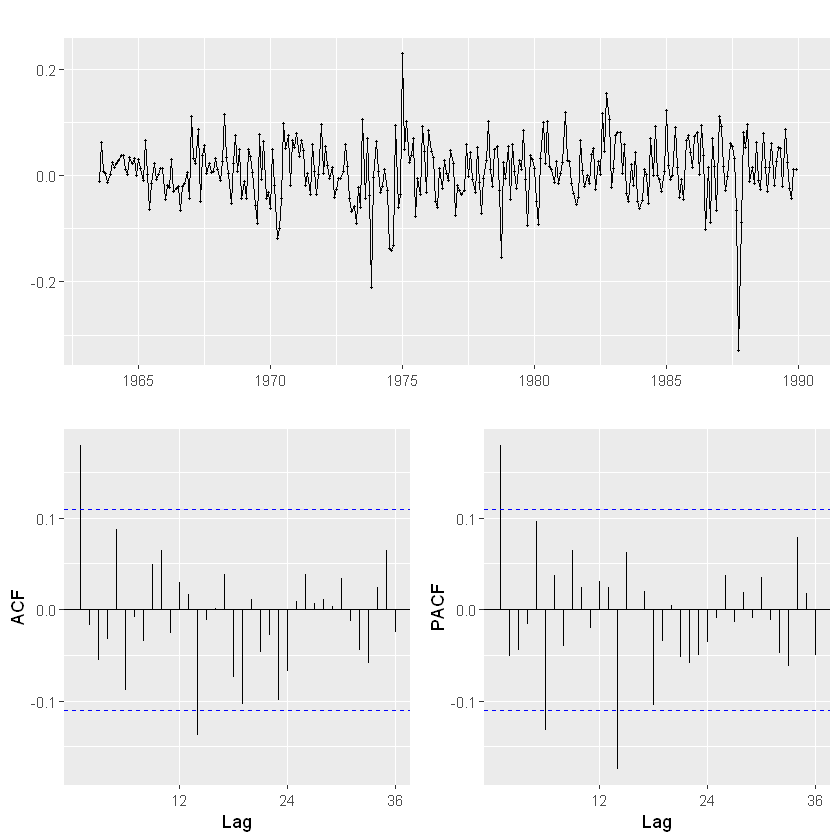

In [10]:
series_train %>% ggtsdisplay()

#### Chọn tham số cho mô hình Dynamic

In [11]:
auto.arima(y = series_train, xreg = X_train, stepwise = FALSE, approximation = FALSE)

Series: series_train 
Regression with ARIMA(0,0,1)(2,0,0)[12] errors 

Coefficients:
         ma1    sar1     sar2  Mkt.RF     SMB     RMW      CMA      RF
      0.2091  0.1911  -0.1587  1.0406  0.2957  0.2787  -0.0022  1.0420
s.e.  0.0589  0.0562   0.0552  0.0319  0.0481  0.1037   0.0930  0.2819

sigma^2 estimated as 0.0005357:  log likelihood=749.92
AIC=-1481.85   AICc=-1481.26   BIC=-1447.99

In [12]:
fit <- Arima(y = series_train, xreg = X_train, order = c(0,0,1))

In [13]:
fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
true <- ts(data = fit$x, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv

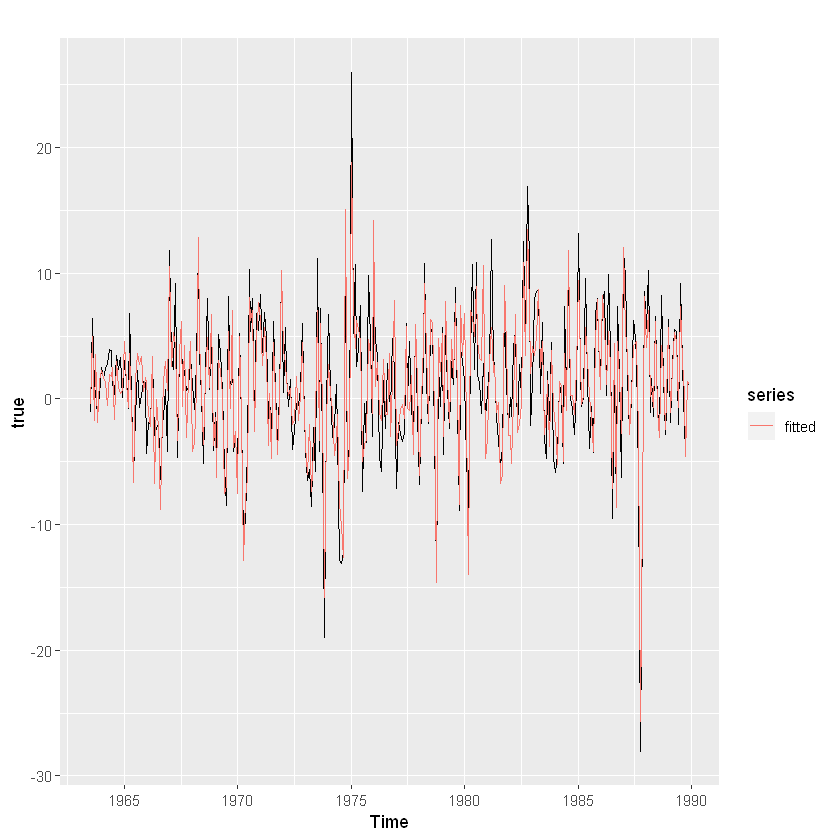

In [14]:
autoplot(true)+autolayer(fitted)

In [15]:
(true - fitted)^2 %>% mean %>% sqrt

[1] 2.387878

#### Chạy thử một số bộ ARIMA trên tập train

In [16]:
order <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA003 = c(0,0,3),
              ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), ARIMA102 = c(1,0,2), ARIMA103 = c(1,0,3),
              ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2), ARIMA203 = c(2,0,3))

In [17]:
result <- NULL
for (o in order)
{
    fit <- Arima(y = series_train, xreg = X_train, order = o)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(order)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-1460.076,-1459.715,-1433.742,2.424795
ARIMA001,-1468.921,-1468.455,-1438.824,2.387878
ARIMA002,-1467.502,-1466.917,-1433.643,2.387807
ARIMA003,-1465.502,-1464.785,-1427.882,2.387815
ARIMA100,-1467.500,-1467.034,-1437.404,2.390883
ARIMA101,-1467.521,-1466.937,-1433.662,2.387981
ARIMA102,-1465.503,-1464.787,-1427.883,2.387826
ARIMA103,-1463.504,-1462.641,-1422.121,2.387826
ARIMA200,-1467.364,-1466.779,-1433.505,2.387772
ARIMA201,-1465.966,-1465.249,-1428.345,2.386486


#### Predict & đánh giá RMSE

In [18]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end=length(series)-388+i) %>% log_scale()
    reg <- X %>% subset(end=length(series)-388+i) %>% log_scale()
    fit <- Arima(y = train, xreg = reg, order = c(2,0,3))
    newreg <- X %>% subset(start=length(series)-387+i, end=length(series)-387+i) %>% log_scale()
    pred_val <- forecast(fit, h = 1, xreg = newreg)$mean %>% log_inv()
    pred <- c(pred, pred_val)
}
pred <- ts(pred, start=c(1990,1), frequency = 12)
true <- series %>% window(start=c(1990,1))
rmse <- sqrt(mean((true-pred)^2))

In [19]:
rmse

[1] 2.405974

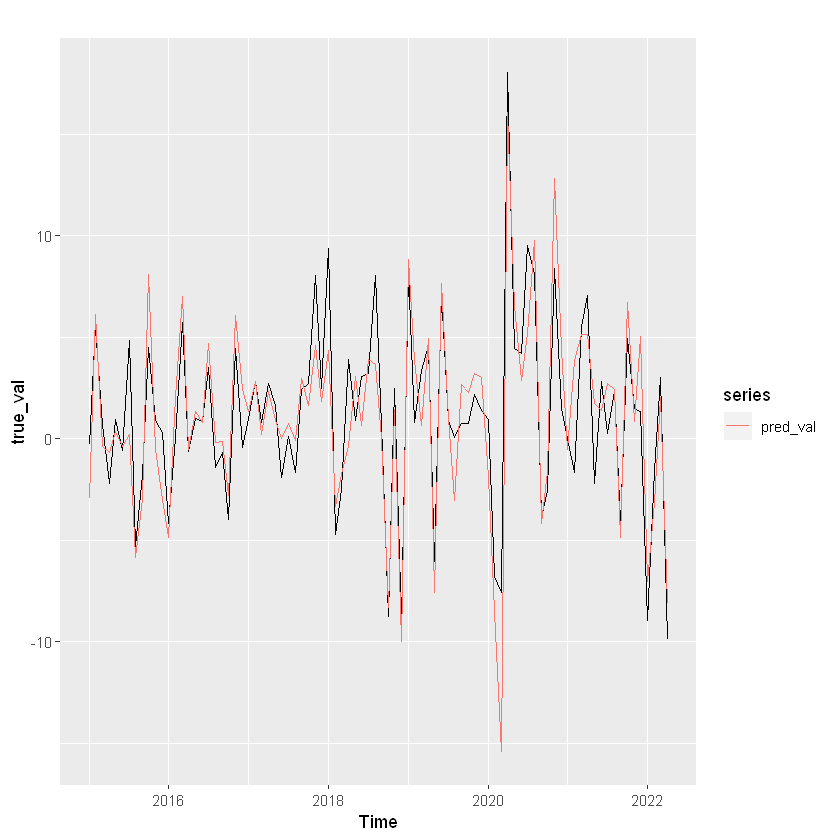

In [20]:
true_val <- true %>% window(start = c(2015,1))
pred_val <- pred %>% window(start = c(2015,1))
autoplot(true_val) + autolayer(pred_val)